In [6]:
import json
with open('02.json', 'r') as f:
    data = json.load(f)

In [7]:
def find_all_tasks(data:dict):
    tasks = []
    for v in data.values():
        if v.get('task_name') not in tasks:
            tasks.append(v.get('task_name'))
    return tasks
tasks = find_all_tasks(data)
print(tasks)

['random_circuit_evolution', 'random_ham_expectation']


In [8]:
def group_by_platform(data:dict, platform:str, task_name:str):
    res={}
    for v in data.values():
        if v['task_name'] == task_name:
            task_params = v['task_params']
            if task_params['platform'] == platform:
                framework, n_qubit, t = task_params['framework'], task_params['n_qubit'], v['mean']
                if framework not in res:
                    res[framework]={'n_qubit':[], 'time':[]}
                res[framework]['n_qubit'].append(n_qubit)
                res[framework]['time'].append(t)
    return res

random_circuit_evolution_cpu = group_by_platform(data, 'cpu', "random_circuit_evolution")
print(random_circuit_evolution_cpu['mindquantum'])

{'n_qubit': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'time': [0.014766125118031222, 0.014853804719214346, 0.015708102899439195, 0.017628529492546532, 0.020866646486170152, 0.028372266713310692, 0.04304378874161664, 0.07242853033776377, 0.12769594379499846, 0.1288844627492568, 0.17859457988365024, 0.2809855493844724, 0.4598723392860562, 0.7899314959843954, 1.02112103797294, 1.037010999286876, 1.164621046611241, 1.5449755787849426, 1.7712700366973877, 2.118008613586426]}


In [9]:
random_circuit_evolution_gpu = group_by_platform(data, 'gpu', "random_circuit_evolution")

In [10]:

random_ham_expectation_cpu = group_by_platform(data, 'cpu', "random_ham_expectation")
random_ham_expectation_gpu = group_by_platform(data, 'gpu', "random_ham_expectation")

In [ ]:

qaoa_2_regular_maxcut_cpu = group_by_platform(data, 'cpu', '2_regular_maxcut')
qaoa_2_regular_maxcut_gpu = group_by_platform(data, 'gpu', '2_regular_maxcut')

In [11]:
import random
def _randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

class RandomColor:
    def __init__(self):
        self.color = ['orange', 'red','royalblue','darkviolet','dodgerblue','sienna','turquoise']
        self.current=-1
    def __call__(self):
        self.current += 1
        if self.current == len(self.color):
            self.current = 0
        return self.color[self.current]
    def reset(self):
        self.current=-1

randomcolor = RandomColor()

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def show_res(task_data, title):
    plt.subplots(dpi=180)
    for k, v in task_data.items():
        ms = 1
        if k == 'mindquantum':
            ms = 2
        if k == 'tensorflow_quantum':  # tensorflow quantum use float type to do calculation
            continue
        plt.plot(v['n_qubit'], v['time'], '--', label=k, c=randomcolor(), lw=ms)
        plt.plot(v['n_qubit'], v['time'], '.', c='black')
    plt.yscale('log')
    plt.legend()
    plt.title(title)
    plt.show()

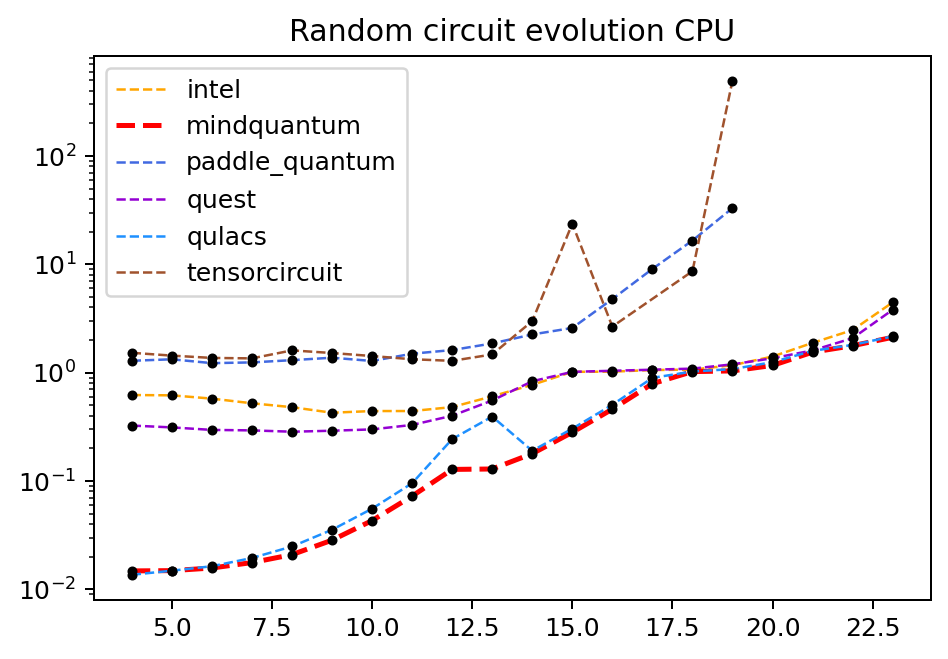

In [13]:
show_res(random_circuit_evolution_cpu, 'Random circuit evolution CPU')

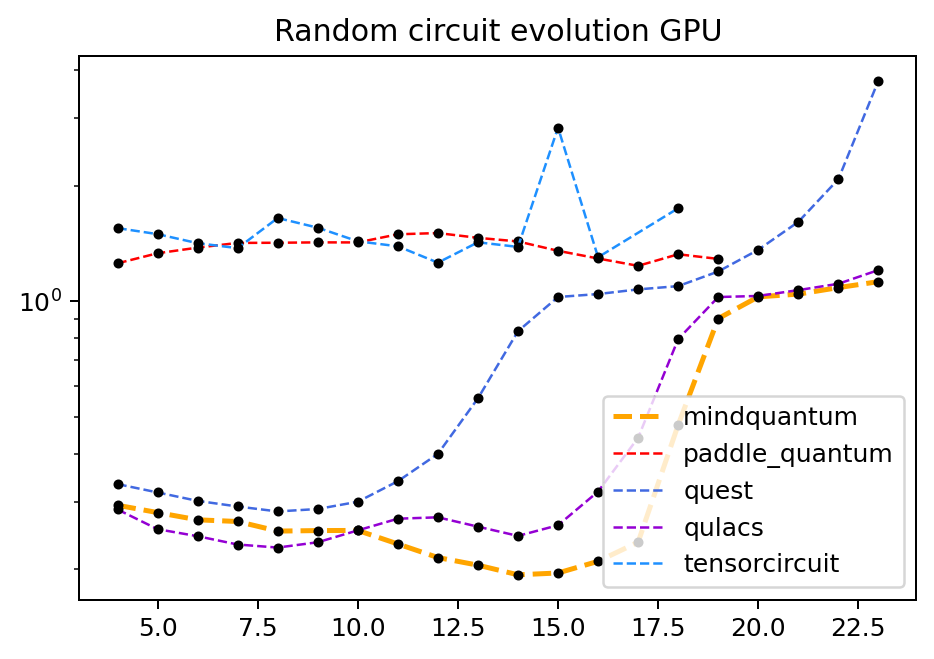

In [14]:
randomcolor.reset()
show_res(random_circuit_evolution_gpu, 'Random circuit evolution GPU')

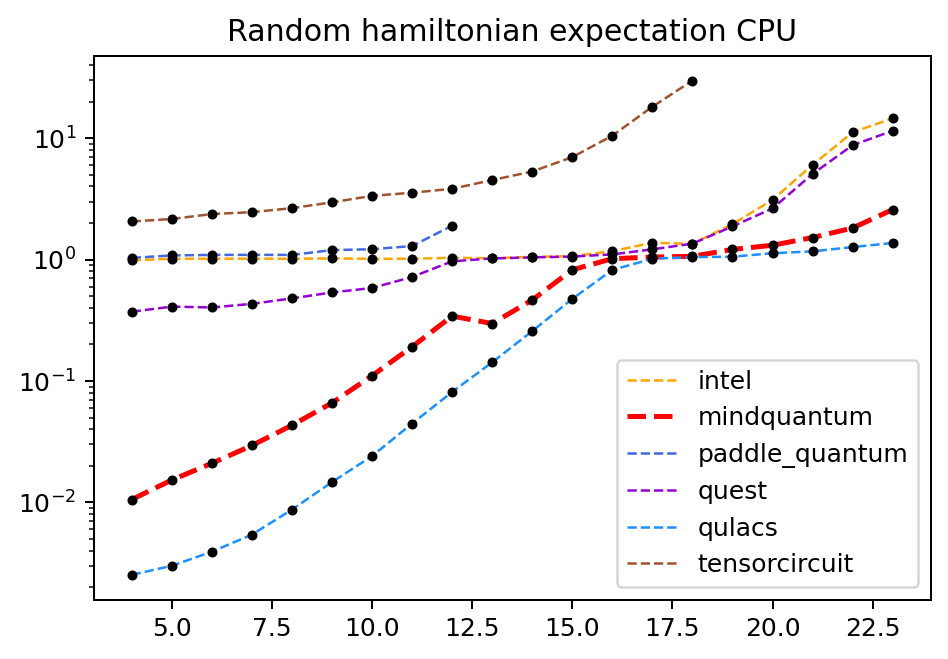

In [15]:
randomcolor.reset()
show_res(random_ham_expectation_cpu, 'Random hamiltonian expectation CPU')

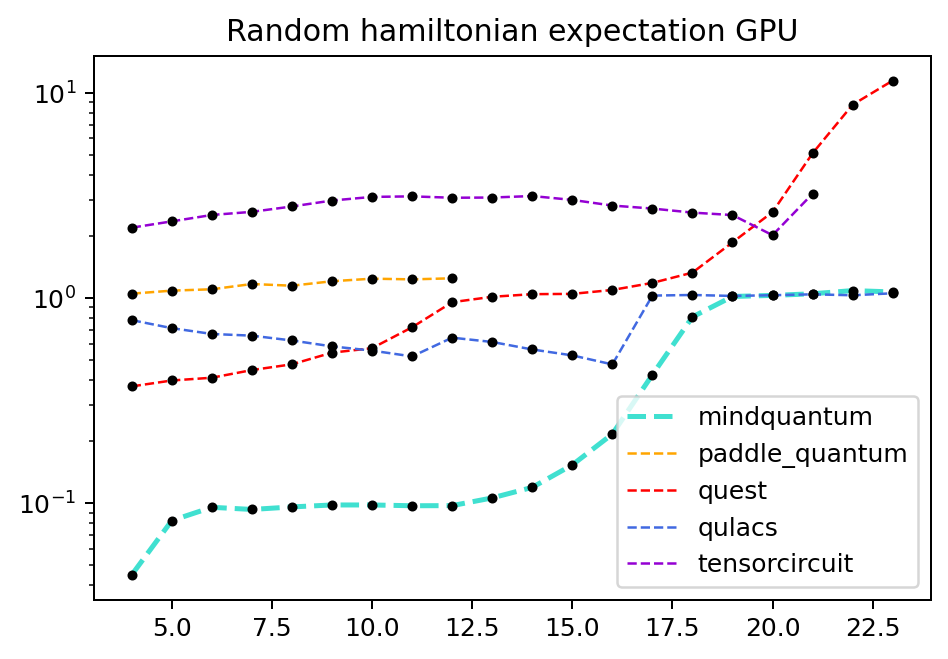

In [16]:
show_res(random_ham_expectation_gpu, 'Random hamiltonian expectation GPU')

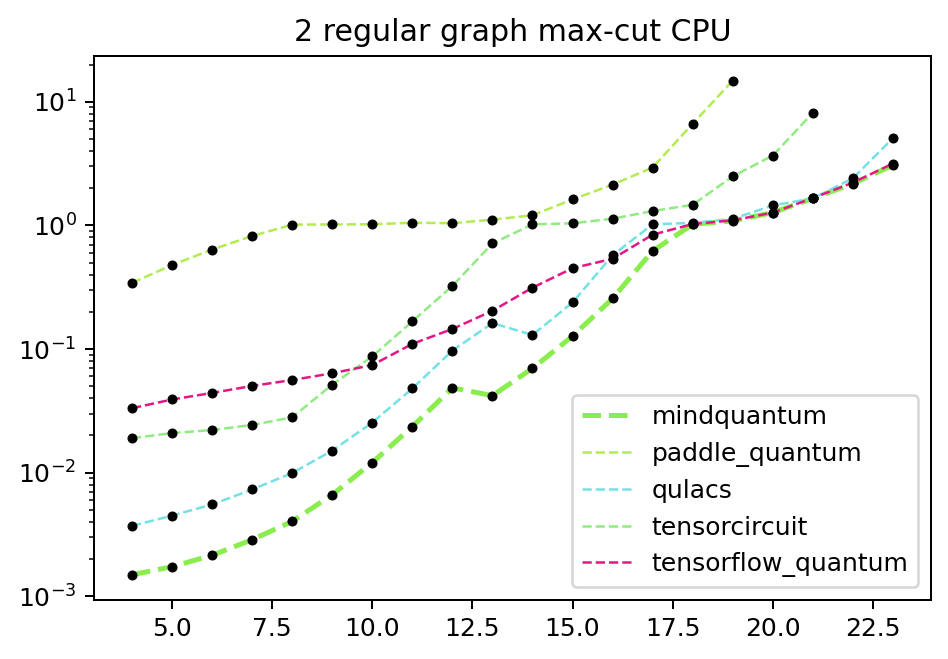

In [65]:
show_res(qaoa_2_regular_maxcut_cpu, '2 regular graph max-cut CPU')

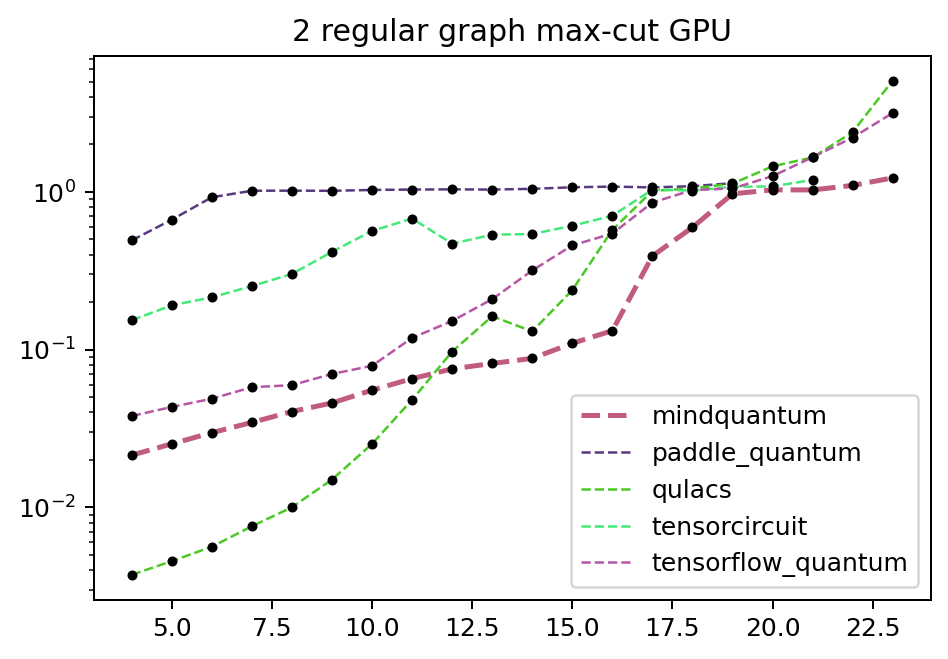

In [66]:
show_res(qaoa_2_regular_maxcut_gpu, '2 regular graph max-cut GPU')